# healthy versus severe

In [1]:
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image 
from six import StringIO
import matplotlib.image as mpimg
#%pylab inline

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

#!pip install biopython
from Bio import Entrez
from Bio import SeqIO

In [2]:
url  = "healthy_versus_severe/healthy.csv"
healthy = pd.read_csv(url,  sep='\t')
healthy['type'] = 'healthy'
healthy.shape[0]

1704

In [3]:
healthy.sample(n=2)

,Unnamed: 0,Region,Position,freq0,frq1,subs,defSubs,converge_RED_AS,RED_freqDiff,p,...,MXE,RI,SE,logFcExp,Delta_Free_energy,genetic_var,most_severe_cons,all_cons,aa_change,codons_change
337,338,chr10,80522222,0,10,TC,TC,0,-4.78430,5.974939e-10,...,0,0,0,0.0,-1.0,T/A/C/G,3_prime_UTR_variant,downstream_gene_variant 3_prime_UTR_variant,NaN,NaN
1618,1619,chr8,97068770,0,9,CT GA,GA,0,-0.07684,1.998893e-06,...,0,0,0,0.0,1.2,G/A/C,intron_variant,intron_variant non_coding_transcript_variant,NaN,NaN


In [4]:
healthy.columns

Index(['Unnamed: 0', 'Region', 'Position', 'freq0', 'frq1', 'subs', 'defSubs',
       'converge_RED_AS', 'RED_freqDiff', 'p', 'p_adj', 'sym', 'ensembl_id',
       'type', 'A3SS', 'A5SS', 'MXE', 'RI', 'SE', 'logFcExp',
       'Delta_Free_energy', 'genetic_var', 'most_severe_cons', 'all_cons',
       'aa_change', 'codons_change'],
      dtype='object')

In [5]:
url  = "healthy_versus_severe/severe.csv"
severe = pd.read_csv(url,  sep=',' )
severe['type'] = 'severe'
severe.shape[0]

1187

In [6]:
severe.sample(n=2)

,Unnamed: 0,Region,Position,freq0,frq1,subs,defSubs,p,p_adj,sym,...,MXE,RI,SE,logFcExp,Delta_Free_energy,genetic_var,most_severe_cons,all_cons,aa_change,codons_change
1128,1133,chrM,7028,1,11,CT,CT,9.917876e-18,3.578504e-14,NaN,...,0,0,0,0.000000,0.0,NaN,intergenic_variant,NaN,NaN,NaN
110,111,chr1,33323919,0,9,CA,CA,3.213160e-08,1.454102e-05,PHC2,...,0,0,2,0.813107,1.1,GC/A C/A/G C/-,3_prime_UTR_variant,3_prime_UTR_variant upstream_gene_variant intr...,NaN,NaN


In [7]:
severe.columns

Index(['Unnamed: 0', 'Region', 'Position', 'freq0', 'frq1', 'subs', 'defSubs',
       'p', 'p_adj', 'sym', 'ensembl_id', 'type', 'A3SS', 'A5SS', 'MXE', 'RI',
       'SE', 'logFcExp', 'Delta_Free_energy', 'genetic_var',
       'most_severe_cons', 'all_cons', 'aa_change', 'codons_change'],
      dtype='object')

In [8]:
df = pd.concat([healthy, severe], ignore_index=True)

In [9]:
df.tail()

,Unnamed: 0,Region,Position,freq0,frq1,subs,defSubs,converge_RED_AS,RED_freqDiff,p,...,MXE,RI,SE,logFcExp,Delta_Free_energy,genetic_var,most_severe_cons,all_cons,aa_change,codons_change
2886,1187,KI270938.1,254489,0,9,TA AT,TA,NaN,NaN,8.894741e-05,...,0,0,0,0.0,0.0,NaN,intergenic_variant,NaN,NaN,NaN
2887,1188,KV880768.1,1464624,0,8,AG TC,AG,NaN,NaN,8.858978e-12,...,0,0,0,0.0,3.4,NaN,intergenic_variant,NaN,NaN,NaN
2888,1189,KZ208915.1,1503009,0,7,GC,GC,NaN,NaN,8.040362e-08,...,0,0,0,0.0,0.9,NaN,intergenic_variant,NaN,NaN,NaN
2889,1190,KZ208915.1,1503228,0,5,TC,TC,NaN,NaN,1.464803e-10,...,0,0,0,0.0,0.0,NaN,intergenic_variant,NaN,NaN,NaN
2890,1191,KZ208915.1,1503670,0,1,GA,GA,NaN,NaN,7.229292e-07,...,0,0,0,0.0,-0.8,NaN,intergenic_variant,NaN,NaN,NaN


In [10]:
def getChromossome( ncbi_id ):
    if "chr" in ncbi_id: 
        return ncbi_id
    else:
        Entrez.email = "waldeyr@gmail.com"
        with Entrez.efetch( db="nucleotide", rettype="gb", id=ncbi_id ) as handle:
            record = SeqIO.read(handle, "gb")
            for f in record.features:
                if f.qualifiers['chromosome'][0]:
                    return "chr" + str(f.qualifiers['chromosome'][0])
                else:
                    return ncbi_id
            
df['Region'] = df['Region'].apply(lambda x: getChromossome(x))

In [11]:
def setRegion(Region):
    if Region == 'chrX': return 23 # chromossome X
    if Region == 'chrY': return 24 # chromossome Y
    if Region == 'chrM': return 25 # Mitochondrial
    return re.sub('chr', '', Region)

df['Region'] = df['Region'].apply(lambda x: setRegion(str(x)))

In [12]:
df = df.fillna(int(0)) # all NaN fields are strings type, so they will be factorize later and the zero will be a category

In [13]:
df.Region           = pd.factorize(df.Region, na_sentinel=None)[0]
df.subs             = pd.factorize(df.subs, na_sentinel=None)[0]
df.defSubs          = pd.factorize(df.defSubs, na_sentinel=None)[0]
df.sym              = pd.factorize(df.sym, na_sentinel=None)[0]
df.ensembl_id       = pd.factorize(df.ensembl_id, na_sentinel=None)[0]
df.type             = pd.factorize(df.type, na_sentinel=None)[0]
df.genetic_var      = pd.factorize(df.genetic_var, na_sentinel=None)[0]
df.most_severe_cons = pd.factorize(df.most_severe_cons, na_sentinel=None)[0]
df.aa_change        = pd.factorize(df.aa_change, na_sentinel=None)[0]
df.codons_change    = pd.factorize(df.codons_change, na_sentinel=None)[0]
df.all_cons         = pd.factorize(df.all_cons, na_sentinel=None)[0]
df.most_severe_cons = pd.factorize(df.most_severe_cons, na_sentinel=None)[0]

In [14]:
df = df.drop(['Unnamed: 0'], axis=1)

In [15]:
df.tail()

,Region,Position,freq0,frq1,subs,defSubs,converge_RED_AS,RED_freqDiff,p,p_adj,...,MXE,RI,SE,logFcExp,Delta_Free_energy,genetic_var,most_severe_cons,all_cons,aa_change,codons_change
2886,10,254489,0,9,15,7,0.0,0.0,8.894741e-05,1.347851e-02,...,0,0,0,0.0,0.0,2,18,20,1,1
2887,7,1464624,0,8,5,5,0.0,0.0,8.858978e-12,7.780805e-09,...,0,0,0,0.0,3.4,2,18,20,1,1
2888,20,1503009,0,7,6,6,0.0,0.0,8.040362e-08,3.242889e-05,...,0,0,0,0.0,0.9,2,18,20,1,1
2889,20,1503228,0,5,10,0,0.0,0.0,1.464803e-10,1.008004e-07,...,0,0,0,0.0,0.0,2,18,20,1,1
2890,20,1503670,0,1,18,10,0.0,0.0,7.229292e-07,2.303384e-04,...,0,0,0,0.0,-0.8,2,18,20,1,1


In [16]:
y = df['type'].values

In [17]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [18]:
X = df.drop(['type'], axis=1)

In [19]:
X.columns

Index(['Region', 'Position', 'freq0', 'frq1', 'subs', 'defSubs',
       'converge_RED_AS', 'RED_freqDiff', 'p', 'p_adj', 'sym', 'ensembl_id',
       'A3SS', 'A5SS', 'MXE', 'RI', 'SE', 'logFcExp', 'Delta_Free_energy',
       'genetic_var', 'most_severe_cons', 'all_cons', 'aa_change',
       'codons_change'],
      dtype='object')

In [20]:
X.dtypes

Region                 int64
Position               int64
freq0                  int64
frq1                   int64
subs                   int64
defSubs                int64
converge_RED_AS      float64
RED_freqDiff         float64
p                    float64
p_adj                float64
sym                    int64
ensembl_id             int64
A3SS                   int64
A5SS                   int64
MXE                    int64
RI                     int64
SE                     int64
logFcExp             float64
Delta_Free_energy    float64
genetic_var            int64
most_severe_cons       int64
all_cons               int64
aa_change              int64
codons_change          int64
dtype: object

In [21]:
X

,Region,Position,freq0,frq1,subs,defSubs,converge_RED_AS,RED_freqDiff,p,p_adj,...,MXE,RI,SE,logFcExp,Delta_Free_energy,genetic_var,most_severe_cons,all_cons,aa_change,codons_change
0,0,109659077,0,8,0,0,0.0,-0.377593,2.973609e-09,1.588855e-06,...,0,0,2,0.0,-1.9,0,0,0,0,0
1,0,111449473,0,2,1,1,0.0,6.825262,3.793190e-04,3.228255e-02,...,2,0,5,0.0,0.0,1,1,1,1,1
2,0,111477647,0,0,2,2,0.0,0.077926,4.589541e-04,3.740250e-02,...,0,0,7,0.0,0.0,2,2,2,1,1
3,0,111477650,0,0,3,3,0.0,0.108752,1.485162e-04,1.608314e-02,...,0,0,7,0.0,0.0,2,3,3,1,1
4,0,111651579,0,10,0,0,0.0,-0.100000,2.922051e-05,4.582295e-03,...,0,0,1,0.0,0.0,0,4,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,10,254489,0,9,15,7,0.0,0.000000,8.894741e-05,1.347851e-02,...,0,0,0,0.0,0.0,2,18,20,1,1
2887,7,1464624,0,8,5,5,0.0,0.000000,8.858978e-12,7.780805e-09,...,0,0,0,0.0,3.4,2,18,20,1,1
2888,20,1503009,0,7,6,6,0.0,0.000000,8.040362e-08,3.242889e-05,...,0,0,0,0.0,0.9,2,18,20,1,1
2889,20,1503228,0,5,10,0,0.0,0.000000,1.464803e-10,1.008004e-07,...,0,0,0,0.0,0.0,2,18,20,1,1


In [22]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 1)

In [23]:
arvore = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=30, random_state=0)

In [26]:
modelo= arvore.fit(X_treino, y_treino)

Populating the interactive namespace from numpy and matplotlib


[Text(837.0, 906.0, 'RED_freqDiff <= 0.0\nentropy = 0.977\nsamples = 2601\nvalue = [1531, 1070]'),
 Text(558.0, 543.6, 'RED_freqDiff <= -0.0\nentropy = 0.941\nsamples = 1666\nvalue = [596, 1070]'),
 Text(279.0, 181.19999999999993, 'entropy = 0.0\nsamples = 596\nvalue = [596, 0]'),
 Text(837.0, 181.19999999999993, 'entropy = 0.0\nsamples = 1070\nvalue = [0, 1070]'),
 Text(1116.0, 543.6, 'entropy = 0.0\nsamples = 935\nvalue = [935, 0]')]

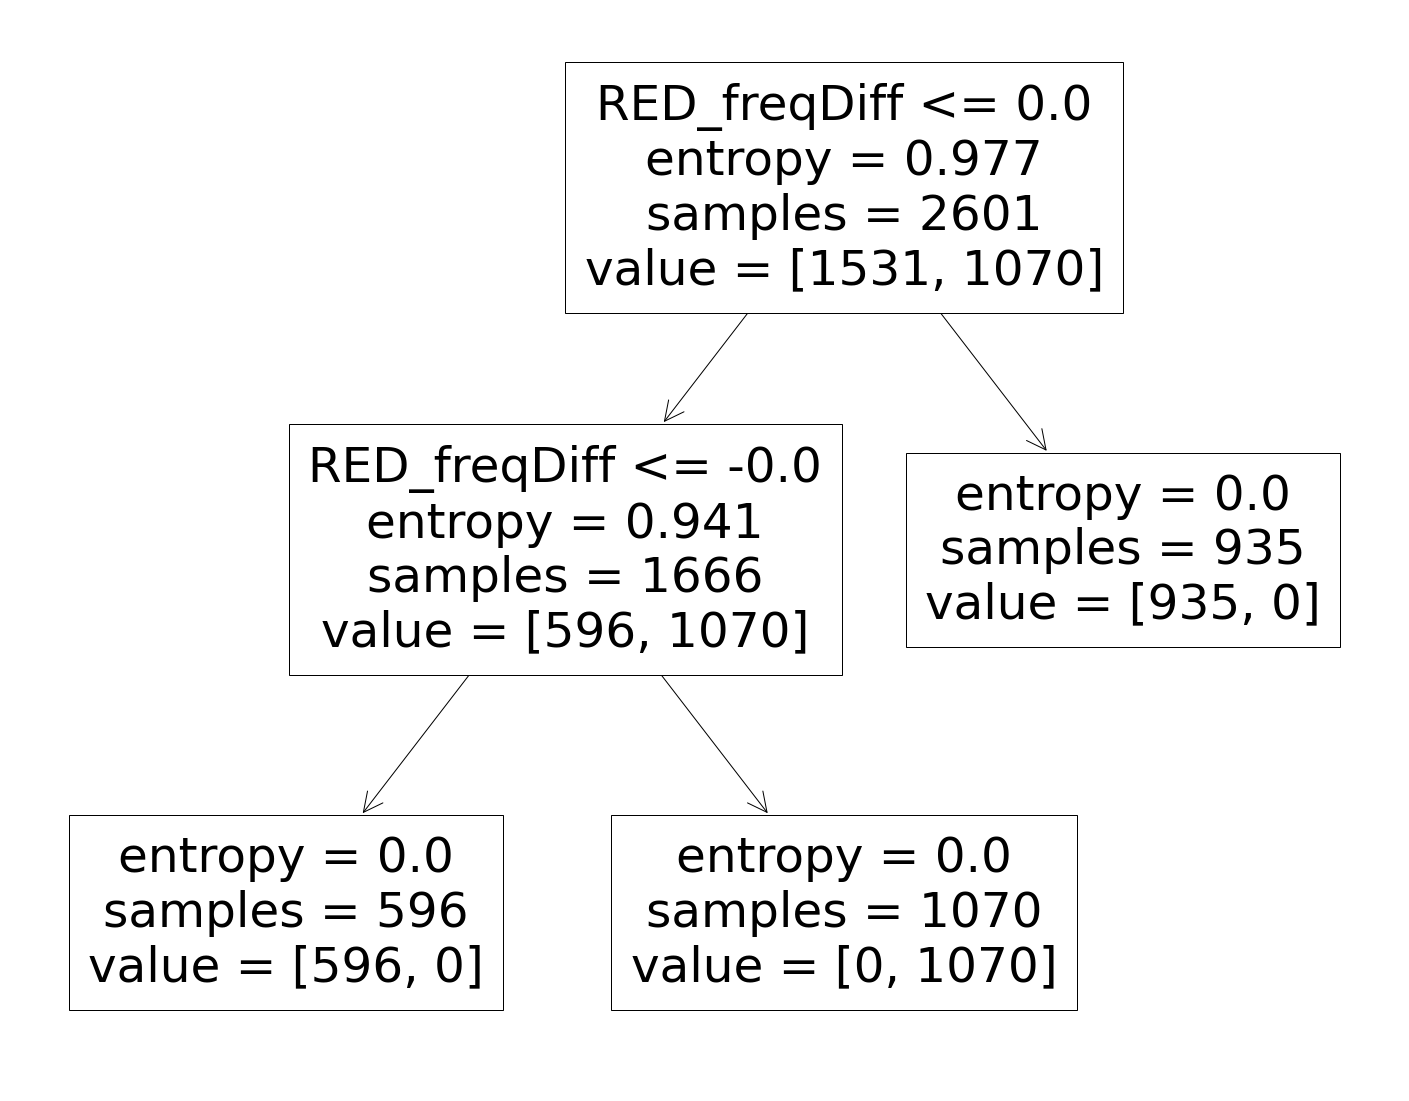

In [27]:
%pylab inline
previsao = arvore.predict(X_teste)
np.sqrt(mean_squared_error(y_teste, previsao))
pylab.figure(figsize=(25,20))
plot_tree(arvore, feature_names=X_treino.columns)

In [28]:
# Aplicando mo modelo gerado na base de testes
y_predicoes = modelo.predict(X_teste)

# Avaliação do modelo
print(f"Acurácia da árvore: {metrics.accuracy_score(y_teste, y_predicoes)}")
print(classification_report(y_teste, y_predicoes))

Acurácia da árvore: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       117

    accuracy                           1.00       290
   macro avg       1.00      1.00      1.00       290
weighted avg       1.00      1.00      1.00       290

